In [15]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first=True) # utilize the LSTM model in torch.nn 
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
 
    def forward(self, input):
        x, _ = self.lstm(input)  # _x is input, size (batch, seq_len, input_size)
        b, s, h = x.shape  # x is output, size (batch,seq_len, hidden_size)
        x = x.contiguous().view(b * s, h )
        x = self.forwardCalculation(x)
        x = x.view(b, s , -1)
        return x

def test():
    # create database
    data_len = 200
    t = np.linspace(0, 12*np.pi, data_len)
    sin_t = np.sin(t)
    cos_t = np.cos(t)

    dataset = np.zeros((data_len, 2))
    dataset[:,0] = sin_t
    dataset[:,1] = cos_t
    dataset = dataset.astype('float32')

    # plot part of the original dataset
    plt.figure()
    plt.plot(t[0:60], dataset[0:60,0], label='sin(t)')
    plt.plot(t[0:60], dataset[0:60,1], label = 'cos(t)')
    plt.plot([2.5, 2.5], [-1.3, 0.55], 'r--', label='t = 2.5') # t = 2.5
    plt.plot([6.8, 6.8], [-1.3, 0.85], 'm--', label='t = 6.8') # t = 6.8
    plt.xlabel('t')
    plt.ylim(-1.2, 1.2)
    plt.ylabel('sin(t) and cos(t)')
    plt.legend(loc='upper right')

    # choose dataset for training and testing
    train_data_ratio = 0.5 # Choose 80% of the data for testing
    train_data_len = int(data_len*train_data_ratio)
#     用sin(x)作为输入，cos(x)作为输出训练LSTM神经网络
    train_x = dataset[:train_data_len, 0]
    train_y = dataset[:train_data_len, 1]
    INPUT_FEATURES_NUM = 1
    OUTPUT_FEATURES_NUM = 1
#     用于训练的x坐标
    t_for_training = t[:train_data_len]

    # test_x = train_x
    # test_y = train_y
    test_x = dataset[train_data_len:, 0]
    test_y = dataset[train_data_len:, 1]
    t_for_testing = t[train_data_len:]

    # ----------------- train -------------------
#     第一维不限制，第一维中每个取出的list都是(5,1)的
    train_x_tensor = train_x.reshape(5,-1,INPUT_FEATURES_NUM)
    train_y_tensor = train_y.reshape(5, -1, OUTPUT_FEATURES_NUM)
    # train_x_tensor = train_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5
    # train_y_tensor = train_y.reshape(-1, 5, OUTPUT_FEATURES_NUM) # set batch size to 5
#     print(train_x_tensor)
 
    # transfer data to pytorch tensor
    train_x_tensor = torch.from_numpy(train_x_tensor)
    train_y_tensor = torch.from_numpy(train_y_tensor)
    # test_x_tensor = torch.from_numpy(test_x)
 
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 16, output_size=OUTPUT_FEATURES_NUM, num_layers=1) # 16 个隐藏层单元
    print('LSTM model:', lstm_model)
    print('model.parameters:', lstm_model.parameters)
#  定义损失函数：均方误差
    loss_function = nn.MSELoss()
#     定义优化器：Adam
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
 
    max_epochs = 10000
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        if loss.item() < 1e-5:
            print('Epoch: [{}/{}], Loss: {:.5f}'.format(epoch+1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch+1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch+1, max_epochs, loss.item()))
 
    # prediction on training dataset
    predictive_y_for_training = lstm_model(train_x_tensor)
    predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    # torch.save(lstm_model.state_dict(), 'model_params.pkl') # save model parameters to files
 
    # ----------------- test -------------------
    # lstm_model.load_state_dict(torch.load('model_params.pkl'))  # load model parameters from files
    lstm_model = lstm_model.eval() # switch to testing model

    # prediction on test dataset
    # 将测试数据转化成张量
    test_x_tensor = test_x.reshape(5, -1, INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set
    test_x_tensor = torch.from_numpy(test_x_tensor)
    # 将预测数据转化成numpy中的向量类型
    predictive_y_for_testing = lstm_model(test_x_tensor)
    predictive_y_for_testing = predictive_y_for_testing.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
    # ----------------- plot -------------------
    plt.figure()
    plt.plot(t_for_training, train_x, 'g', label='sin_trn')
    plt.plot(t_for_training, train_y, 'b', label='ref_cos_trn')
    plt.plot(t_for_training, predictive_y_for_training, 'y--', label='pre_cos_trn')

    plt.plot(t_for_testing, test_x, 'c', label='sin_tst')
    plt.plot(t_for_testing, test_y, 'k', label='ref_cos_tst')
    plt.plot(t_for_testing, predictive_y_for_testing, 'm--', label='pre_cos_tst')
# 画直线，传入：起点和终点的x坐标 & 起点和终点的y坐标
    plt.plot([t[train_data_len], t[train_data_len]], [-1.2, 4.0], 'r--', label='separation line') # separation line

    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.xlim(t[0], t[-1])
    plt.ylim(-1.2, 4)
    plt.legend(loc='upper right')
    plt.text(14, 2, "train", size = 15, alpha = 1.0)
    plt.text(20, 2, "test", size = 15, alpha = 1.0)

    plt.show()

LSTM model: LstmRNN(
  (lstm): LSTM(1, 16, batch_first=True)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(1, 16, batch_first=True)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)>
Epoch: [100/10000], Loss:0.08553
Epoch: [200/10000], Loss:0.04751
Epoch: [300/10000], Loss:0.03201
Epoch: [400/10000], Loss:0.02345
Epoch: [500/10000], Loss:0.01817
Epoch: [600/10000], Loss:0.01408
Epoch: [700/10000], Loss:0.00844
Epoch: [800/10000], Loss:0.00534
Epoch: [900/10000], Loss:0.00251
Epoch: [1000/10000], Loss:0.00120
Epoch: [1100/10000], Loss:0.00046
Epoch: [1200/10000], Loss:0.00016
Epoch: [1300/10000], Loss:0.00006
Epoch: [1400/10000], Loss:0.00003
Epoch: [1500/10000], Loss:0.00001
Epoch: [1600/10000], Loss:0.00001
Epoch: [1604/10000], Loss: 0.00001
The loss value is reached


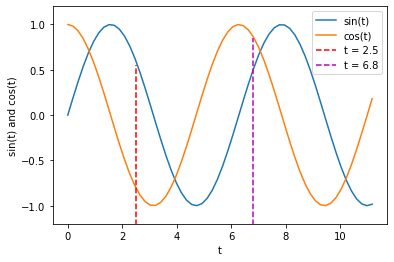

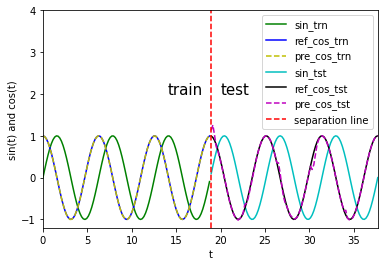

In [16]:
test()

In [17]:
import pandas as pd
def lstm_prediction():
    # create database
    df = pd.read_csv('AirPassengers.csv')
    data_len = df.shape[0]

    # plot part of the original dataset
    plt.figure()
    x_time = df['date']
    plt.figure(figsize=(16,10), dpi= 80)
    plt.plot('date', 'traffic', data = df, color='tab:red')

    # Decoration
    plt.ylim(50, 750)
    # 按照一定的间隔部署x轴的标签
    # 索引划分，将索引划分成间隔12的
    # 将x数据（时间）划分，划分成十二个月份为一个周期的
    xtick_location = df.index.tolist()[::12]
    print(df.date.tolist()[::12])
    xtick_labels = [x[:] for x in df.date.tolist()[::12]]
    plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=30, fontsize=12, horizontalalignment='center', alpha=.7)
    plt.yticks(fontsize=12, alpha=.7)
    plt.title("Air Passengers Traffic (1949 - 1969)", fontsize=22)
    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)   

    # choose dataset for training and testing
    train_data_ratio = 0.8 # Choose 80% of the data for testing
    train_data_len = int(data_len*train_data_ratio)
#     用sin(x)作为输入，cos(x)作为输出训练LSTM神经网络
    train_x = np.array(df.index[:train_data_len]).astype('float32')
    train_y = np.array(df['traffic'][:train_data_len]).astype('float32')
    INPUT_FEATURES_NUM = 1
    OUTPUT_FEATURES_NUM = 1
#     用于训练的x坐标
    t_for_training = train_x

    test_x = np.array(df.index[train_data_len:]).astype('float32')
    test_y = np.array(df['traffic'].loc[train_data_len:]).astype('float32')
    t_for_testing = test_x

    # ----------------- train -------------------
#     第一维不限制，第一维中每个取出的list都是(5,1)的
    train_x_tensor = train_x.reshape(-1, 1, INPUT_FEATURES_NUM) # set batch size to 5
    train_y_tensor = train_y.reshape(-1, 1, OUTPUT_FEATURES_NUM) # set batch size to 5
 
    # transfer data to pytorch tensor
    train_x_tensor = torch.from_numpy(train_x_tensor)
    train_y_tensor = torch.from_numpy(train_y_tensor)
 
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 16, output_size=OUTPUT_FEATURES_NUM, num_layers=1) # 16 个隐藏层单元
    print('LSTM model:', lstm_model)
    print('model.parameters:', lstm_model.parameters)
#  定义损失函数：均方误差
    loss_function = nn.MSELoss()
#     定义优化器：Adam
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
#     开始迭代
    max_epochs = 10000
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        if loss.item() < 1e-4:
            print('Epoch: [{}/{}], Loss: {:.5f}'.format(epoch+1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch+1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch+1, max_epochs, loss.item()))
 
    # prediction on training dataset
    predictive_y_for_training = lstm_model(train_x_tensor)
    predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    # torch.save(lstm_model.state_dict(), 'model_params.pkl') # save model parameters to files
 
    # ----------------- test -------------------
    # lstm_model.load_state_dict(torch.load('model_params.pkl'))  # load model parameters from files
    lstm_model = lstm_model.eval() # switch to testing model

    # prediction on test dataset
    # 将测试数据转化成张量
    test_x_tensor = test_x.reshape(-1, 1, INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set
    test_x_tensor = torch.from_numpy(test_x_tensor)
    # 将预测数据转化成numpy中的向量类型
    predictive_y_for_testing = lstm_model(test_x_tensor)
    predictive_y_for_testing = predictive_y_for_testing.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    # ----------------- plot -------------------
#     train picture
    plt.plot(t_for_training, train_y, 'b', label='train_data')
    plt.plot(t_for_training, predictive_y_for_training, 'y--', label='predicted_train_data')

    plt.plot(t_for_testing, test_y, 'c', label='test_raw_data')
    plt.plot(t_for_testing, predictive_y_for_testing, 'm--', label='predicted_test_data')
    plt.legend(loc='upper right')
    plt.show()

# 客流数据的可视化与预测

['1949/1/1', '1950/1/1', '1951/1/1', '1952/1/1', '1953/1/1', '1954/1/1', '1955/1/1', '1956/1/1', '1957/1/1', '1958/1/1', '1959/1/1', '1960/1/1']
LSTM model: LstmRNN(
  (lstm): LSTM(1, 16, batch_first=True)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(1, 16, batch_first=True)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)>
Epoch: [100/10000], Loss:58905.28516
Epoch: [200/10000], Loss:52741.15625
Epoch: [300/10000], Loss:47414.25391
Epoch: [400/10000], Loss:42659.49609
Epoch: [500/10000], Loss:38386.40625
Epoch: [600/10000], Loss:34542.51562
Epoch: [700/10000], Loss:31089.32031
Epoch: [800/10000], Loss:27994.93945
Epoch: [900/10000], Loss:25231.26562
Epoch: [1000/10000], Loss:22772.63477
Epoch: [1100/10000], Loss:20595.07422
Epoch: [1200/10000], Loss:18675.90625
Epoch: [1300/10000], Loss:16993.22852
Epoch: [1400/10000], Loss:15477.90039
Epoch: [1500/100

<Figure size 432x288 with 0 Axes>

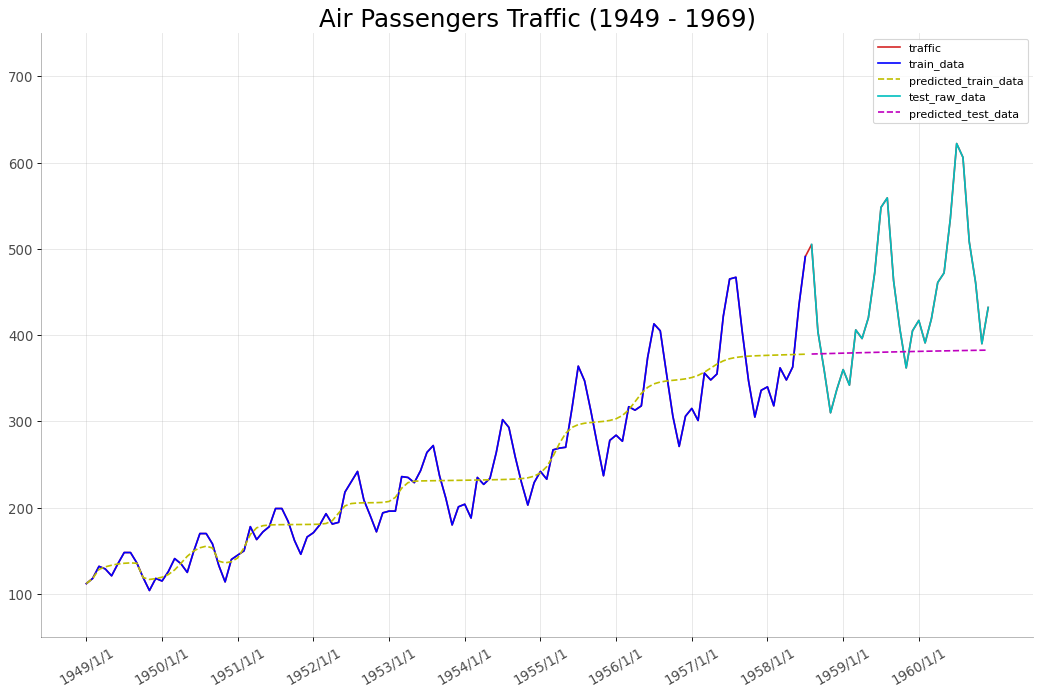

In [18]:
lstm_prediction()

# 客流数据的正确的预测（长期预测）

(143, 3)
torch.Size([107])
torch.Size([95, 96, 1])
Training Start
torch.Size([96, 95])
Epoch:    0, Loss: 0.21867
Epoch:   64, Loss: 0.01786
Epoch:  128, Loss: 0.00756
Epoch:  192, Loss: 0.00400
Epoch:  256, Loss: 0.00309
Epoch:  320, Loss: 0.00256
Epoch:  384, Loss: 0.00217
Epoch:  448, Loss: 0.00185
Save in: ./net.pth
torch.Size([107, 1, 1])
test_y[-1]: tensor([[0.4402]], grad_fn=<SelectBackward>)
L1: 0.262    L2: 0.085


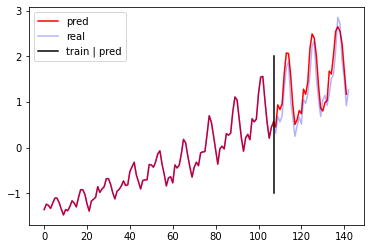

In [86]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

def run_train_lstm():
    inp_dim = 3
    out_dim = 1
#     中间的网络宽度
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 8
    mod_dir = '.'

    '''load data'''
#     data.shape=(144,3)
    data = load_data()
    data_x = data[:-1, :]
    print(data_x.shape)
#   data_y是序列数据
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
#   评价准则是：均方误差
    criterion = nn.MSELoss()
#     优化器：Adam
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

# 剪裁出足够多的序列进行训练
    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    # 构造从0-1的权重
    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)
    # len(train_y)=107
    print(weights.shape)  
    # torch.Size([95, 96, 1])
    print(batch_var_y.shape)
    weights = weights[:batch_size - 1]
    print("Training Start")
    for e in range(500):
        out = net(batch_var_x)
        # out.shape=[95,96,1]
        MSE = (out - batch_var_y) ** 2
        loss = MSE.view(batch_size - 1,batch_size).transpose(0,1)
        if e==0:
            print(loss.shape)# [95, 96, 107]
            # print(out[:,0,0])   
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir),
                                   map_location=lambda storage, loc: storage))
    net = net.eval()
    # data_x是缺少了最后一个数据的数据集
    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim),
                           dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
    # test_y.shape = [seq_len,1,1]
    print(test_y.shape)
    print("test_y[-1]:",test_y[-1])
    test_x[train_size, 0, 0] = test_y[-1].squeeze()
    # 通过第i个预测第i+1个，
    for i in range(train_size, len(test_x) - 1):
        test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1].squeeze()
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
#     L1损失：平均绝对误差
    l1_loss = np.mean(np.abs(diff_y))
#     L2损失：均方误差
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real', alpha=0.3)
#     垂直线：将train数据划分在左边，test数据划分在右边
    plt.plot([train_size, train_size], [-1, 2],
             color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('lstm_reg.png')
    plt.pause(4)


#     注册一个LSTM模型
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()
        
        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc



def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype=np.float32)
    # assert seq_number.shape == (144, )
    # plt.plot(seq_number)
    # plt.ion()
    # plt.pause(1)
#     增加一个维度，将第二维变成列表形式
    seq_number = seq_number[:, np.newaxis]

    # print(repr(seq))
    # 1949~1960, 12 years, 12*12==144 month
    seq_year = np.arange(12)
    seq_month = np.arange(12)
    seq_year_month = np.transpose(
        [np.repeat(seq_year, len(seq_month)),
         np.tile(seq_month, len(seq_year))],
    )  # Cartesian Product
# 数据结构 seq=(原始数据，年份，月份)
    seq = np.concatenate((seq_number, seq_year_month), axis=1)
    # print(seq.shape)
    # print(seq)
    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    
    return seq


if __name__ == '__main__':
    run_train_lstm()
    # run_train_gru()
    # run_origin()

In [82]:
class RegGRU(nn.Module):
    def __init__(self, inp_dim, out_dim, mod_dim, mid_layers):
        super(RegGRU, self).__init__()

        self.rnn = nn.GRU(inp_dim, mod_dim, mid_layers)
        self.reg = nn.Linear(mod_dim, out_dim)

    def forward(self, x):
        x, h = self.rnn(x)  # (seq, batch, hidden)

        seq_len, batch_size, hid_dim = x.shape
        x = x.view(-1, hid_dim)
        x = self.reg(x)
        x = x.view(seq_len, batch_size, -1)
        return x

    def output_y_h(self, x, h):
        y, h = self.rnn(x, h)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, h

def run_origin():
    inp_dim = 2
    out_dim = 1
    mod_dir = '.'

    '''load data'''
    data = load_data()  # axis1: number, year, month
    data_x = np.concatenate((data[:-2, 0:1], data[+1:-1, 0:1]), axis=1)
    data_y = data[2:, 0]

    train_size = int(len(data_x) * 0.75)
    train_x = data_x[:train_size]
    train_y = data_y[:train_size]

    train_x = train_x.reshape((-1, 1, inp_dim))
    train_y = train_y.reshape((-1, 1, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim=4, mid_layers=2).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    print('var_x.size():', var_x.size())
    print('var_y.size():', var_y.size())

    for e in range(512):
        out = net(var_x)
        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (e + 1) % 100 == 0:  # 每 100 次输出结果
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))

    '''eval'''
    # net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()  # 转换成测试模式

    """
    inappropriate way of seq prediction: 
    use all real data to predict the number of next month
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    var_data = torch.tensor(test_x, dtype=torch.float32, device=device)
    eval_y = net(var_data)  # 测试集的预测结果
    pred_y = eval_y.view(-1).cpu().data.numpy()

    plt.plot(pred_y[1:], 'r', label='pred inappr', alpha=0.3)
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], label='train | pred')

    """
    appropriate way of seq prediction: 
    use real+pred data to predict the number of next 3 years.
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    test_x[train_size:] = 0  # delete the data of next 3 years.
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
    for i in range(train_size, len(data) - 2):
        test_y = net(test_x[:i])
        test_x[i, 0, 0] = test_x[i - 1, 0, 1]
        test_x[i, 0, 1] = test_y[-1, 0]
    pred_y = test_x.cpu().data.numpy()
    pred_y = pred_y[:, 0, 0]
    plt.plot(pred_y[2:], 'g', label='pred appr')

    plt.legend(loc='best')
    plt.savefig('gru_origin.png')
    plt.pause(4)


def run_train_gru():
    inp_dim = 3
    out_dim = 1
#     中间的网络宽度
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 8
    mod_dir = '.'

    '''load data'''
#     data.shape=(144,3)
    data = load_data()
    data_x = data[:-1, :]
    print(data_x.shape)
#   data_y是序列数据
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegGRU(inp_dim, out_dim, mid_dim, mid_layers).to(device)
#   评价准则是：均方误差
    criterion = nn.MSELoss()
#     优化器：Adam
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

# 剪裁出足够多的序列进行训练
    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    # 构造从0-1的权重
    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)
    # len(train_y)=107
    print(weights.shape)  
    # torch.Size([95, 96, 1])
    print(batch_var_y.shape)
    print("Training Start")
    for e in range(500):
        out = net(batch_var_x)
        # out.shape=[95,96,1]
        MSE = (out - batch_var_y) ** 2
        loss = MSE.view(batch_size - 1,batch_size).transpose(0,1) * weights[:batch_size - 1]
        if e==0:
            print(loss.shape)# [95, 96, 107]
            # print(out[:,0,0])   
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir),
                                   map_location=lambda storage, loc: storage))
    net = net.eval()
    # data_x是缺少了最后一个数据的数据集
    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim),
                           dtype=torch.float32, device=device)
    test_y, h = net.output_y_h(test_x[:train_size], zero_ten)
    # test_y.shape = [seq_len,1,1]
    print(test_y.shape)
    print("test_y[-1]:",test_y[-1])
    test_x[train_size, 0, 0] = test_y[-1].squeeze()
    # 通过第i个预测第i+1个，
    for i in range(train_size, len(test_x) - 1):
        test_y, h = net.output_y_h(test_x[i:i + 1], h)
        test_x[i + 1, 0, 0] = test_y[-1].squeeze()
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
#     L1损失：平均绝对误差
    l1_loss = np.mean(np.abs(diff_y))
#     L2损失：均方误差
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real', alpha=0.3)
#     垂直线：将train数据划分在左边，test数据划分在右边
    plt.plot([train_size, train_size], [-1, 2],
             color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('gru_reg.png')
    plt.pause(4)


(143, 3)
torch.Size([107])
torch.Size([95, 96, 1])
Training Start
torch.Size([96, 95])
Epoch:    0, Loss: 0.13122
Epoch:   64, Loss: 0.01319
Epoch:  128, Loss: 0.00435
Epoch:  192, Loss: 0.00268
Epoch:  256, Loss: 0.00165
Epoch:  320, Loss: 0.00112
Epoch:  384, Loss: 0.00082
Epoch:  448, Loss: 0.00060
Save in: ./net.pth
torch.Size([107, 1, 1])
test_y[-1]: tensor([[0.4576]], grad_fn=<SelectBackward>)
L1: 0.180    L2: 0.047


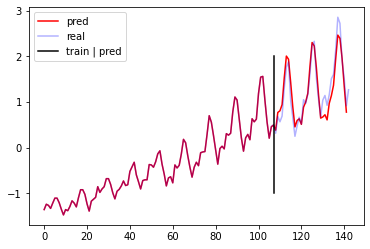

In [83]:
run_train_gru()

var_x.size(): torch.Size([106, 1, 2])
var_y.size(): torch.Size([106, 1, 1])
Epoch: 100, Loss: 0.02070
Epoch: 200, Loss: 0.01293
Epoch: 300, Loss: 0.01294
Epoch: 400, Loss: 0.01037
Epoch: 500, Loss: 0.00923


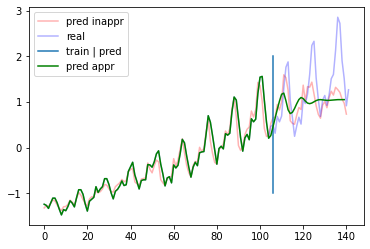

In [77]:
run_origin()